In [ ]:
import pandas as pd


adress = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\adresses-69.csv", sep=";")
adress.info()

In [ ]:
adress.head()

In [ ]:
adress.isna().sum().sort_values(ascending=False).head(100)

In [ ]:
dpe_existant = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\dpe-v2-logements-existants.csv", sep=",")
dpe_existant.head()

In [ ]:
dpe_neuf = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\dpe-v2-logements-neufs.csv", sep=",")
dpe_neuf.info()

In [ ]:
dpe_neuf.head()

In [ ]:
dpe_existant.shape

In [ ]:
dpe_existant.isna().sum().sort_values(ascending=False).head(100)

In [ ]:
dpe_neuf.shape

In [ ]:
dpe_neuf.isna().sum().sort_values(ascending=False).head(100)

In [24]:
dpe_neuf_no_empty_columns = dpe_neuf.dropna(axis=1, how='all')
dpe_existant_no_empty_columns = dpe_existant.dropna(axis=1, how='all')

In [25]:
dpe_existant["Logement"] = "ancien"
dpe_neuf["Logement"] = "neuf"

In [26]:
dpe_neuf["Année_construction"] = 2024

In [27]:
common_columns = dpe_existant.columns.intersection(dpe_neuf.columns)
common_columns = common_columns.to_list()

In [ ]:
df_concat = pd.concat([dpe_existant, dpe_neuf], join='inner', ignore_index=True)
df_concat

In [ ]:
df_concat["Annee_reception_DPE"] = pd.to_datetime(df_concat['Date_réception_DPE']).dt.year
df_concat["Annee_reception_DPE"].head(10)

In [ ]:
df_concat['Somme_coûts'] = df_concat['Coût_chauffage'] + df_concat['Coût_éclairage'] + df_concat['Coût_ECS'] + df_concat['Coût_refroidissement'] + df_concat['Coût_auxiliaires']

# Créer une colonne pour vérifier si le coût total correspond à la somme
df_concat['Vérification_coût_total'] = df_concat['Coût_total_5_usages'] == df_concat['Somme_coûts']

In [ ]:
df_concat['Vérification_coût_total']

In [ ]:
df_concat["Coût chauffage en %"] = (df_concat['Coût_chauffage']/df_concat['Coût_total_5_usages'])*100
df_concat["Coût chauffage en %"]

In [33]:
def periode_contruct(annee):
    if annee <= 1960:
        return "Avant 1960"
    if annee >= 1961 and annee <= 1970:
        return "1961 - 1970"
    if annee >= 1971 and annee <= 1970:
        return "1971 - 1980"
    if annee >= 1981 and annee <= 1990:
        return "1981 - 1990"
    if annee >= 1991 and annee <= 2000:
        return "1991 - 2000"
    if annee >= 2000 and annee <= 2010:
        return "2001 - 2010"
    if annee > 2010:
        return "Après 2010"

In [ ]:
df_concat["Periode_construction"] = df_concat["Année_construction"].apply(periode_contruct)

In [ ]:
df_concat["Année_construction"]

# Statistiques


In [ ]:
 df_concat['Etiquette_DPE'].value_counts()

In [ ]:
 df_concat['Date_réception_DPE'].value_counts()

In [ ]:
 df_concat['Logement'].value_counts()

In [ ]:

df_concat['Type_bâtiment'].value_counts()

In [ ]:

df_concat['Type_installation_chauffage'].value_counts()

In [ ]:
df_concat['Surface_habitable_logement'].mean()

In [ ]:
df_concat['Coût_chauffage'].mean()

In [ ]:
df_concat["Coût_ECS"].quantile([.1, .25, .5, .75])

In [ ]:
df_concat[["Surface_habitable_logement", "Coût_chauffage"]].corr()

In [ ]:
df_concat[["Coût_total_5_usages","Coût_chauffage","Coût_éclairage","Coût_ECS","Coût_refroidissement", "Coût_auxiliaires", "Surface_habitable_logement" , "Emission_GES_5_usages"]].corr()

In [ ]:
df_appart = df_concat[df_concat["Type_bâtiment"] == "appartement"]
df_appart

# Bases ML

In [47]:
df = df_concat

In [ ]:
df['Etiquette_DPE'].value_counts(normalize=True)

In [ ]:
df["passoire_energetique"] = df["Etiquette_DPE"].isin(["F", "G"])

In [ ]:
df["passoire_energetique"].value_counts(normalize=True)

In [51]:
# Vérification des données manquantes
ls_variables_explicatives = ['Année_construction','Surface_habitable_logement','Coût_total_5_usages','Coût_ECS','Coût_chauffage','Coût_éclairage','Coût_auxiliaires','Coût_refroidissement','Type_énergie_n°1']

In [ ]:
df[ls_variables_explicatives].isnull().sum()

In [53]:
variables_continues = ['Année_construction','Surface_habitable_logement','Coût_total_5_usages','Coût_ECS','Coût_chauffage','Coût_éclairage','Coût_auxiliaires','Coût_refroidissement']

for col in variables_continues:
    df[col].fillna(df[col].mean(), inplace=True)

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

sub_df = df[df['Surface_habitable_logement']<500]
plt.figure(figsize=(8, 6))
sns.histplot(sub_df['Surface_habitable_logement'], bins=30, kde=True)
plt.title('Distribution de la Surface habitable')
plt.xlabel('Surface (m²)')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Calcul de la matrice de corrélation
corr_matrix = df[variables_continues].corr()

# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

In [ ]:

# Boxplot de chaque variable explicative par rapport à la passoire énergétique
for col in variables_continues:
    plt.figure(figsize=(8, 6))
    
    # Tracer le boxplot sans les outliers
    sns.boxplot(x='passoire_energetique', y=col, data=df, showfliers=False)
    
    # Automatiser le titre avec le nom de la colonne
    plt.title(f'Boxplot de {col} en Fonction de la Passoire Énergétique')
    
    plt.xlabel('Passoire Énergétique (True = F/G, False = A à E)')
    plt.ylabel(f'{col}')  # Automatiser l'étiquette de l'axe y avec le nom de la colonne
    plt.show()


In [57]:
# Concaténer les deux listes : ls_variables_explicatives et ['passoire_energetique']
df = df[ls_variables_explicatives + ['passoire_energetique']]

In [58]:
df = pd.get_dummies(df, columns=['Type_énergie_n°1'], drop_first=True)

In [ ]:
df.head()

## Echantillonnage

In [60]:
X = df[df.columns.difference(['passoire_energetique'])]

In [61]:
X = df[variables_continues]

In [62]:
Y = df["passoire_energetique"]

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.30,
                                                    stratify = Y,
                                                    random_state = 42)

In [ ]:
y_train.value_counts(normalize=True)


In [ ]:
y_test.value_counts(normalize=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)
X_test.head()

In [67]:
from sklearn.tree import DecisionTreeClassifier
model_arbre = DecisionTreeClassifier(max_depth=3 , min_samples_leaf=50, min_samples_split=100)
model_arbre = model_arbre.fit(X_train,y_train)

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16,4))
plot_tree(model_arbre,feature_names = list(X.columns),filled=True, fontsize=10)
plt.show()

In [ ]:
y_pred = model_arbre.predict(X_test)
y_pred

In [ ]:
y_pred_proba = model_arbre.predict_proba(X_test)
y_pred_proba[0:10]

In [ ]:
from sklearn.metrics import confusion_matrix
mc = pd.DataFrame(confusion_matrix(y_test,y_pred),
                  columns=['pred_0','pred_1'],
                  index=['obs_0','obs_1'])

mc

#ou 

pd.crosstab(y_test,y_pred, colnames=['pred'], rownames=['obs'], margins=True)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import recall_score, precision_score
print('recall :' + str(recall_score(y_test,y_pred,average='binary', pos_label=0)))
print('precision : ' + str(precision_score(y_test,y_pred, average='binary', pos_label=0)))

In [ ]:
from sklearn.metrics import f1_score
print('f1_score : ' + str(f1_score(y_test,y_pred, average='binary', pos_label=0)))

In [ ]:
print('recall : ' + str(recall_score(y_test,y_pred,average='macro')))
print('precision : ' + str(precision_score(y_test,y_pred, average='macro')))
print('f1_score : ' + str(f1_score(y_test,y_pred, average='macro')))

In [ ]:
print('recall : ' + str(recall_score(y_test,y_pred,average='weighted')))
print('precision : ' + str(precision_score(y_test,y_pred, average='weighted')))
print('f1_score : ' + str(f1_score(y_test,y_pred, average='weighted')))

## Validation croisée

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report

model_arbre_cv = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(model_arbre_cv, X_train, y_train, cv=5, scoring='f1_macro')

print(f"Scores de validation croisée:{cv_scores}") # permet de savoir comment le modele prédit (surapprentissage ?)
print(f"Moyenne des scores de validation croisée : {cv_scores.mean()}")

model_arbre_cv.fit(X_train, y_train)

y_pred_arbre_cv = model_arbre.predict(X_test)

print(classification_report(y_test, y_pred_arbre_cv)) # permet d'avoir l'ensemble les scores des metriques recall, precision , f1
print(f"Accuracy sur l'ensemble de test: {accuracy_score(y_test, y_pred_arbre_cv)}")

In [78]:
import numpy as np 

parameters = {
    'max_depth': np.arange(start=1, stop=10, step=1),
    'min_samples_leaf': np.arange(start = 5, stop = 250, step = 50),
    'min_samples_split': np.arange(start = 10, stop = 500, step = 50)
}

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

model_arbre_grid = DecisionTreeClassifier()
score = make_scorer(f1_score, pos_label=0)
model_arbre_grid = GridSearchCV(model_arbre_grid, parameters, scoring=score, verbose=2, cv=5)
model_arbre_grid.fit(X_train, y_train)

In [ ]:
print("Voici les paramètres du meilleure modèle : " + str(model_arbre_grid.best_estimator_))
print("Voici le "  + str(model_arbre_grid.scorer_) + " du meilleure modèle : " + str(model_arbre_grid.best_score_))

In [81]:
# Prédictions sur l'ensemble de test
y_pred_arbre_grid = model_arbre_grid.predict(X_test)

In [ ]:
# Évaluation du modèle
print(classification_report(y_test, y_pred_arbre_grid))
print(f"Accuracy sur l'ensemble de test : {accuracy_score(y_test, y_pred_arbre_grid)}")
print('recall :' + str(recall_score(y_test,y_pred,average='binary', pos_label=0)))
print('precision : ' + str(precision_score(y_test,y_pred, average='binary', pos_label=0)))
print('f1_score : ' + str(f1_score(y_test,y_pred, average='binary', pos_label=0)))

In [83]:
# Prédire les probabilités pour la classe positive (1)
y_proba_cv = model_arbre_cv.predict_proba(X_test)[:, 1]
y_proba_grid = model_arbre_grid.predict_proba(X_test)[:, 1]

In [84]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calculer les courbes ROC
fpr1, tpr1, _ = roc_curve(y_test, y_proba_cv)
fpr2, tpr2, _ = roc_curve(y_test, y_proba_grid)

# Calculer l'AUC pour chaque modèle
auc1 = roc_auc_score(y_test, y_proba_cv)
auc2 = roc_auc_score(y_test, y_proba_grid)

In [ ]:
import matplotlib.pyplot as plt
# Tracer les courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Arbre CV (AUC = {auc1:.2f})', color='blue')
plt.plot(fpr2, tpr2, label=f'Arbre Grid (AUC = {auc2:.2f})', color='green')

# Ajouter la diagonale (aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label='Modèle aléatoire')

# Ajouter des labels et un titre
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Comparaison des courbes ROC entre deux modèles')
plt.legend(loc='lower right')

# Afficher le graphique
plt.show()

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(X_train, y_train)



In [87]:
y_pred_knn = model_knn.predict(X_test)

In [ ]:
print('f1_score : ' + str(f1_score(y_test,y_pred_knn,average='binary', pos_label=1)))

In [ ]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log_model = reg_log.fit(X_train, y_train)
y_pred_reg = reg_log_model.predict(X_test)

print('f1_score : ' + str(f1_score(y_test,y_pred_reg,average='binary', pos_label=1)))

In [ ]:
reg_log_model.predict_proba(X_test)[0:10]

In [ ]:
coef = pd.DataFrame(reg_log_model.coef_[0,] ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = reg_log_model.intercept_
coef

### Aller plus loin avec SMOTE pour ré équilibrer les classes

In [92]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [93]:
from imblearn.over_sampling import BorderlineSMOTE

oversample = BorderlineSMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

### Aller plus loin avec SHAP pour interpréter ses modèles

In [ ]:
#! pip install shap

In [105]:
import shap

# Créer un explainer basé sur le modèle Random Forest
explainer = shap.TreeExplainer(rf_model)

# Calculer les valeurs SHAP pour les données de test
shap_values = explainer.shap_values(X_test)

In [135]:
# Expliquer la première prédiction dans le jeu de test
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


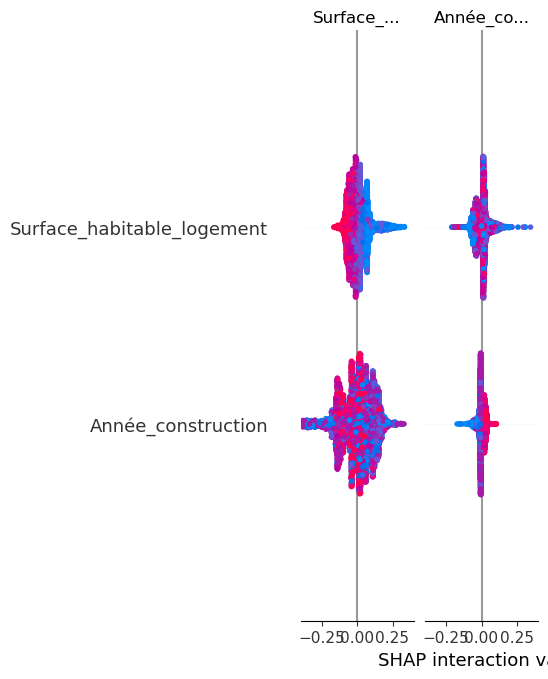

In [101]:
# Importance globale des caractéristiques (summary plot)
shap.summary_plot(shap_values, X_test)

### KNN over sampling

In [106]:
knn_smote = KNeighborsClassifier(n_neighbors=3)
knn_smote.fit(X_train_smote, y_train_smote)
y_pred_knn_smote = knn_smote.predict(X_test)

In [107]:
print('f1_score : ' + str(f1_score(y_test,y_pred_knn_smote,average='binary', pos_label=1)))

f1_score : 0.6401354784081288


In [108]:
from imblearn.over_sampling import BorderlineSMOTE

oversample = BorderlineSMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

## Regression logistique

In [109]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log_model = reg_log.fit(X_train, y_train)
y_pred_reg = reg_log_model.predict(X_test)

print('f1_score : ' + str(f1_score(y_test,y_pred_reg,average='binary', pos_label=1)))

f1_score : 0.5170278637770898


In [110]:
reg_log_model.predict_proba(X_test)[0:10]

array([[9.99710573e-01, 2.89426864e-04],
       [9.91573723e-01, 8.42627652e-03],
       [9.88540625e-01, 1.14593753e-02],
       [9.70918641e-01, 2.90813586e-02],
       [7.39380759e-01, 2.60619241e-01],
       [8.36462898e-01, 1.63537102e-01],
       [9.61211759e-01, 3.87882414e-02],
       [9.60350840e-01, 3.96491598e-02],
       [9.94152372e-01, 5.84762782e-03],
       [9.84426180e-01, 1.55738202e-02]])

In [111]:
# les coefficient du modèle
coef = pd.DataFrame(reg_log_model.coef_[0,] ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = reg_log_model.intercept_
coef

,Coef
Année_construction,-0.000477
Surface_habitable_logement,-0.014933
Coût_total_5_usages,-0.009060
Coût_ECS,0.007166
Coût_chauffage,0.012508
Coût_éclairage,-0.076391
Coût_auxiliaires,0.000062
Coût_refroidissement,0.002302
Constante,0.000071


## Random forest 

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=0)

rf_model = rf_clf.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print('f1_score: '+ str(f1_score(y_test, y_pred_rf, average='binary', pos_label=1)))

pd.crosstab(y_test, y_pred, colnames=['pred'], rownames=['obs'] , margins=True)

f1_score: 0.8466819221967962


pred,False,True,All
obs,,,
False,5174,37,5211
True,296,169,465
All,5470,206,5676


In [112]:
pd.DataFrame(rf_model.feature_importances_,
             index=X_train.columns.tolist(),
             columns=['Importances']).sort_values(by = 'Importances', ascending=False)

,Importances
Coût_chauffage,0.223722
Coût_éclairage,0.198477
Coût_total_5_usages,0.194151
Surface_habitable_logement,0.179203
Coût_auxiliaires,0.076532
Coût_ECS,0.073574
Année_construction,0.050933
Coût_refroidissement,0.003408


## Régression

### Variable cible

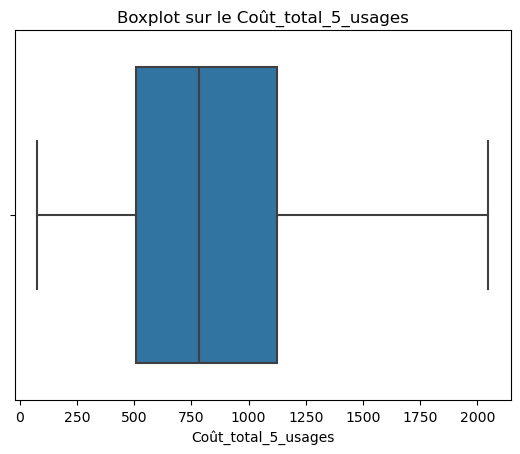

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

target = "Coût_total_5_usages"

# Créer un boxplot pour une colonne spécifique
sns.boxplot(data=df, x = target, showfliers=False)

# Afficher le graphique
plt.title(f'Boxplot sur le {target}')
plt.show()

In [114]:
import pandas as pd
import numpy as np

# Créer une séquence de 0 à 1 avec un pas de 0.1
sequence = np.arange(0, 1.1, 0.1)

# Calculer les déciles (0.1, 0.2, ..., 0.9) en ajoutant les percentiles à describe()
resultat = df[target].describe(percentiles=sequence)

In [115]:
# Changer l'option pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Changer l'option pour afficher toutes les lignes
pd.set_option('display.max_rows', None)

## Variables explicatives

In [116]:
# Vérification des données manquantes
ls_variables_explicatives = ['Année_construction','Surface_habitable_logement','Type_énergie_n°1',
'Etiquette_DPE',
'N°_étage_appartement', 'Hauteur_sous-plafond',
'Logement_traversant_(0/1)',
'Présence_brasseur_air_(0/1)',
'Indicateur_confort_été',
'Isolation_toiture_(0/1)',
'Protection_solaire_exterieure_(0/1)',
'Inertie_lourde_(0/1)',
'Deperditions_baies_vitrées',
'Deperditions_enveloppe',
'Déperditions_murs',
'Deperditions_planchers_bas',
'Deperditions_planchers_hauts',
'Déperditions_ponts_thermiques',
'Déperditions_portes',
'Déperditions_renouvellement_air',
'Qualité_isolation_enveloppe',
'Qualité_isolation_menuiseries',
'Qualité_isolation_murs',
'Qualité_isolation_plancher_bas']

In [117]:
# Créer une séquence de 0 à 1 avec un pas de 0.1
sequence = np.arange(0, 1.1, 0.1)

# Calculer les déciles (0.1, 0.2, ..., 0.9) en ajoutant les percentiles à describe()
resultat = df.describe(percentiles=sequence)

In [118]:
# Vérification des données manquantes
df_concat[ls_variables_explicatives].isnull().sum()

Année_construction                        0
Surface_habitable_logement                0
Type_énergie_n°1                          0
Etiquette_DPE                             0
N°_étage_appartement                   4377
Hauteur_sous-plafond                      0
Logement_traversant_(0/1)              8855
Présence_brasseur_air_(0/1)            8855
Indicateur_confort_été                 8855
Isolation_toiture_(0/1)                8969
Protection_solaire_exterieure_(0/1)    8855
Inertie_lourde_(0/1)                   9079
Deperditions_baies_vitrées             2869
Deperditions_enveloppe                 2869
Déperditions_murs                      2869
Deperditions_planchers_bas             2882
Deperditions_planchers_hauts           2879
Déperditions_ponts_thermiques          2871
Déperditions_portes                    2874
Déperditions_renouvellement_air        2869
Qualité_isolation_enveloppe               0
Qualité_isolation_menuiseries             0
Qualité_isolation_murs          

In [119]:
from sklearn.impute import KNNImputer

# Sélectionner uniquement les colonnes quantitatives (numériques)
quant_cols = df_concat[ls_variables_explicatives].select_dtypes(include=[np.number]).columns

# Afficher les colonnes quantitatives
print("Colonnes quantitatives :", quant_cols)

# Initialiser le KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Appliquer l'imputation sur les colonnes quantitatives
df_concat[quant_cols] = imputer.fit_transform(df_concat[quant_cols])

# Vérification des données manquantes
df_concat[quant_cols].isnull().sum()

Colonnes quantitatives : Index(['Année_construction', 'Surface_habitable_logement',
       'N°_étage_appartement', 'Hauteur_sous-plafond',
       'Logement_traversant_(0/1)', 'Présence_brasseur_air_(0/1)',
       'Isolation_toiture_(0/1)', 'Protection_solaire_exterieure_(0/1)',
       'Inertie_lourde_(0/1)', 'Deperditions_baies_vitrées',
       'Deperditions_enveloppe', 'Déperditions_murs',
       'Deperditions_planchers_bas', 'Deperditions_planchers_hauts',
       'Déperditions_ponts_thermiques', 'Déperditions_portes',
       'Déperditions_renouvellement_air'],
      dtype='object')


Année_construction                     0
Surface_habitable_logement             0
N°_étage_appartement                   0
Hauteur_sous-plafond                   0
Logement_traversant_(0/1)              0
Présence_brasseur_air_(0/1)            0
Isolation_toiture_(0/1)                0
Protection_solaire_exterieure_(0/1)    0
Inertie_lourde_(0/1)                   0
Deperditions_baies_vitrées             0
Deperditions_enveloppe                 0
Déperditions_murs                      0
Deperditions_planchers_bas             0
Deperditions_planchers_hauts           0
Déperditions_ponts_thermiques          0
Déperditions_portes                    0
Déperditions_renouvellement_air        0
dtype: int64

In [120]:
# Sélectionner toutes les colonnes non numériques (qualitatives)
categorical_cols = df_concat[ls_variables_explicatives].select_dtypes(exclude=[np.number]).columns

# Appliquer l'imputation par la valeur la plus fréquente (mode) pour chaque colonne catégorielle
for col in categorical_cols:
    df_concat[col] = df_concat[col].fillna(df_concat[col].mode()[0])

# Vérification des données manquantes
df_concat[categorical_cols].isnull().sum()

Type_énergie_n°1                  0
Etiquette_DPE                     0
Indicateur_confort_été            0
Qualité_isolation_enveloppe       0
Qualité_isolation_menuiseries     0
Qualité_isolation_murs            0
Qualité_isolation_plancher_bas    0
dtype: int64

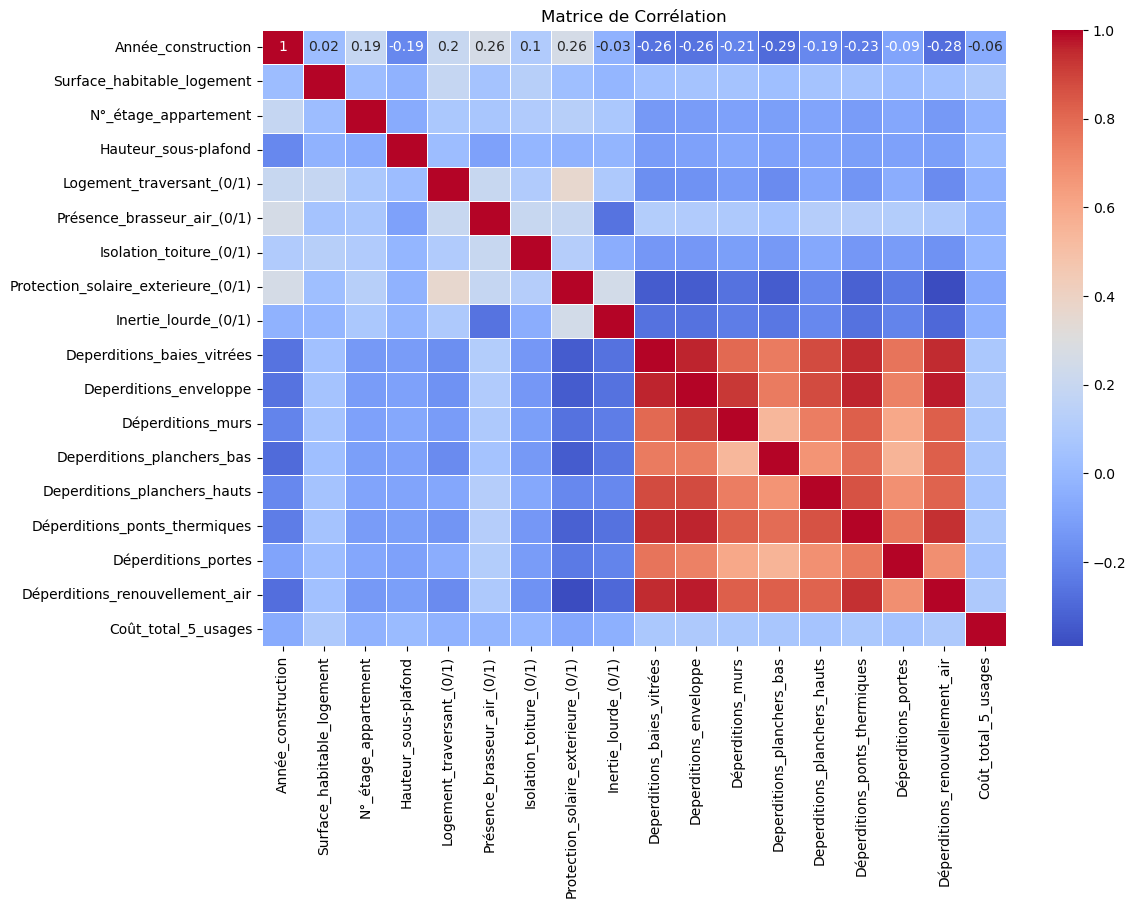

In [121]:
# Calcul de la matrice de corrélation
corr_matrix = round(df_concat[list(quant_cols) + [target] ].corr(),2)
# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

In [122]:
# Concaténer les deux listes : ls_variables_explicatives et target
df = df_concat[list(ls_variables_explicatives) + [target]]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Echantillonnage

In [123]:
# Utiliser set.difference() pour exclure la colonne cible de ls_variables_explicatives
X =df[df.columns.difference([target])]

In [124]:
Y = df[target]

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.30,
                                                    random_state = 42)

In [126]:
print(X_train.shape)
print(X_test.shape)
X_test.head()

(13244, 44)
(5676, 44)


,Année_construction,Deperditions_baies_vitrées,Deperditions_enveloppe,Deperditions_planchers_bas,Deperditions_planchers_hauts,Déperditions_murs,Déperditions_ponts_thermiques,Déperditions_portes,Déperditions_renouvellement_air,Etiquette_DPE_B,Etiquette_DPE_C,Etiquette_DPE_D,Etiquette_DPE_E,Etiquette_DPE_F,Etiquette_DPE_G,Hauteur_sous-plafond,Indicateur_confort_été_insuffisant,Indicateur_confort_été_moyen,Inertie_lourde_(0/1),Isolation_toiture_(0/1),Logement_traversant_(0/1),N°_étage_appartement,Protection_solaire_exterieure_(0/1),Présence_brasseur_air_(0/1),Qualité_isolation_enveloppe_insuffisante,Qualité_isolation_enveloppe_moyenne,Qualité_isolation_enveloppe_très bonne,Qualité_isolation_menuiseries_insuffisante,Qualité_isolation_menuiseries_moyenne,Qualité_isolation_menuiseries_très bonne,Qualité_isolation_murs_insuffisante,Qualité_isolation_murs_moyenne,Qualité_isolation_murs_très bonne,Qualité_isolation_plancher_bas_insuffisante,Qualité_isolation_plancher_bas_moyenne,Qualité_isolation_plancher_bas_très bonne,Surface_habitable_logement,Type_énergie_n°1_Bois – Granulés (pellets) ou briquettes,Type_énergie_n°1_Bois – Plaquettes forestières,Type_énergie_n°1_Fioul domestique,Type_énergie_n°1_GPL,Type_énergie_n°1_Gaz naturel,Type_énergie_n°1_Réseau de Chauffage urbain,Type_énergie_n°1_Électricité
18457,2024.000000,26.366667,111.4,26.8,0.0,12.433333,18.5,0.0,27.333333,True,False,False,False,False,False,2.5,False,True,0.0,0.000000,1.0,0.333333,1.0,1.000000,False,False,False,False,False,True,False,False,True,False,False,True,67.7,False,False,False,False,False,True,False
5282,1988.839438,7.300000,26.9,0.0,0.0,3.000000,4.5,3.7,8.600000,False,False,False,True,False,False,2.5,False,True,0.0,0.000000,0.0,0.000000,1.0,0.000000,True,False,False,False,True,False,False,False,False,False,False,True,18.4,False,False,False,False,False,False,True
4525,1988.839438,42.400000,102.9,0.0,0.0,7.600000,13.8,0.0,39.100000,False,True,False,False,False,False,2.5,False,True,1.0,0.000000,0.0,0.000000,1.0,0.000000,False,False,True,True,False,False,True,False,False,False,False,True,69.6,False,False,False,False,False,True,False
17372,2024.000000,82.300000,0.4,41.0,29.8,160.200000,264.1,82.3,439.800000,True,False,False,False,False,False,2.5,False,True,0.0,0.333333,1.0,3.333333,1.0,0.000000,False,False,False,False,False,True,False,False,True,False,False,True,61.1,False,False,False,False,False,True,False
10504,2006.000000,1152.100000,5648.5,57.1,307.2,588.600000,972.9,14.8,2555.800000,False,True,False,False,False,False,2.7,False,True,0.0,0.000000,1.0,0.000000,1.0,0.666667,False,True,False,False,False,False,False,False,False,False,False,False,92.5,False,False,False,False,True,False,False


## Régression linéaire multiple

In [127]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model = lr_model.fit(X_train,y_train)

In [128]:
coef = pd.DataFrame(lr_model.coef_ ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = lr_model.intercept_
coef

,Coef
Année_construction,1.618991e+00
Deperditions_baies_vitrées,2.971337e-02
Deperditions_enveloppe,-1.423960e-01
Deperditions_planchers_bas,-7.007041e-01
Deperditions_planchers_hauts,8.372150e-02
Déperditions_murs,2.532645e-01
Déperditions_ponts_thermiques,1.488407e-01
Déperditions_portes,-6.659160e-01
Déperditions_renouvellement_air,3.608966e-01
Etiquette_DPE_B,2.686231e+02


## Evaluation de modèle

In [129]:
y_pred = lr_model.predict(X_test)
y_pred

array([-154.57273907,  938.36803371,   51.95531068, ...,  346.39413539,
       2163.2824538 ,  602.2926149 ])

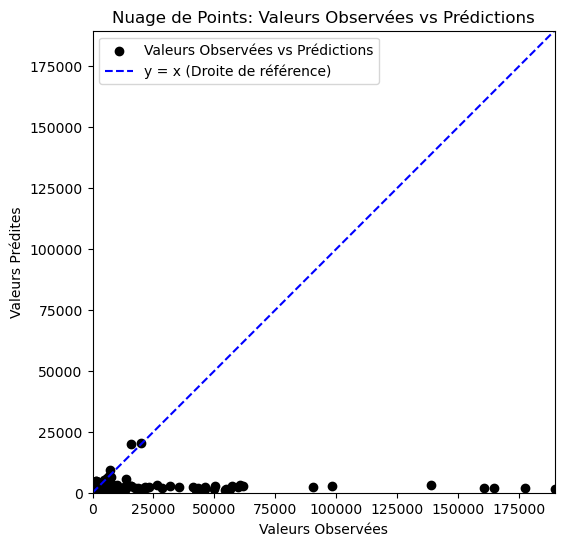

In [130]:
# Taille de la figure
plt.figure(figsize=(10, 6))

# Nuage de points pour les valeurs observées et prédites
plt.scatter(y_test, y_pred, color='black', label='Valeurs Observées vs Prédictions')

# Tracer la droite d'équation y = x
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='blue', linestyle='--', label='y = x (Droite de référence)')

# Définir les limites des axes
plt.xlim(0, max_val)
plt.ylim(0, max_val)

# Assurer que les axes ont la même échelle
plt.gca().set_aspect('equal', adjustable='box')

# Ajouter des labels et une légende
plt.xlabel('Valeurs Observées')
plt.ylabel('Valeurs Prédites')
plt.title('Nuage de Points: Valeurs Observées vs Prédictions')
plt.legend()

# Afficher le graphique
plt.show()

In [131]:
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("R² : " + str(r2_score(y_test, y_pred)))

RMSE : 5941.421167637796
R² : 0.01830237579193328


## D'autres méthodes

### Ridge

In [ ]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=0)
ridge_model = ridge_model.fit(X_train,y_train)

y_pred = ridge_model.predict(X_test)

print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("R² : " + str(r2_score(y_test, y_pred)))

In [ ]:
coef = pd.DataFrame(ridge_model.coef_ ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = ridge_model.intercept_
coef

### Lasso

In [ ]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=10)
lasso_model = lasso_model.fit(X_train,y_train)

y_pred = lasso_model.predict(X_test)

print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("R² : " + str(r2_score(y_test, y_pred)))

In [ ]:
coef = pd.DataFrame(lasso_model.coef_ ,
                    index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = lasso_model.intercept_
coef